In [ ]:
# NOTE:
# Regular PINN with loss normalization. This normalization ensures that the loss from physics and data are always circa equal. This means that even though the 
# loss from data goes down a lot, we still update it on equal terms as with the physics. 

In [125]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import random

#from model import PINN

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:

def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True,
                               allow_unused=True)



class NNBlock(nn.Module):
    """
    Standard Feed Forward Neural Network 
    """
    def __init__(self, in_chan, out_chan, chans=[5,10,5], dropout_prob=0.1):
        super().__init__()

        #self.in_block = nn.Linear(in_chan, chans[0])

        layers = []

        layers.append(nn.Linear(in_chan, chans[0]))
        layers.append(nn.Tanh())
        #layers.append(nn.Dropout(p=dropout_prob))

        for i in range(len(chans) - 1):
            layers.append(nn.Linear(chans[i], chans[i+1]))
            layers.append(nn.Tanh())
            #layers.append(nn.Dropout(p=dropout_prob))

        layers.append(nn.Linear(chans[-1], out_chan))

        self.blocks = nn.Sequential(*layers)

    def forward(self, x):
        #y = torch.sin(self.in_block(x))
        #return self.blocks(y)
    
        return self.blocks(x)


class PINN(nn.Module):
    """
    Physics Informed Neural Network. 
        * physical_loss :
            Calculates the physical loss using 
            - returns torch.tensor
    """
    def __init__(self, in_chan=1, out_chan=1, chans=[5,10,5]):
        super().__init__()

        # Predicts Chi
        self.nn = NNBlock(in_chan, out_chan, chans=chans)
        #self.nn = ffnn(in_chan, out_chan)

        #self.e_ = torch.nn.Parameter(torch.tensor(0.8))
        #self.mu_ = torch.nn.Parameter(torch.tensor(0.00018))
        #self.M_ = torch.nn.Parameter(torch.tensor(.04))

        self.e_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        self.mu_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        self.M_ = torch.nn.Parameter(torch.abs(torch.randn(1)/10))
        #self.p_ = torch.nn.Parameter(torch.abs(torch.randn(1)))

        # Use initial guess
        #self.e_ = torch.nn.Parameter(torch.arctanh(torch.log(torch.tensor(0.5)))) # 0.8
        #self.M_ = torch.nn.Parameter(torch.log(torch.tensor(0.01))) # 0.04
        #self.p_ = torch.nn.Parameter(torch.log(torch.tensor(200.))) # 220.

        # Enable gradient for trainable parameters
        self.e_requires_grad = True
        self.mu_.requires_grad = True
        self.M_.requires_grad = True
        #self.p_.requires_grad = True

    def forward(self, x):
        # Output u

        mu = self.get_mu()#.item()
        #p = self.get_p()
        M  = self.get_M()
        e  = self.get_e()#.item()

        u = mu/M * (1 + e*torch.cos(self.nn(x)))
        return u
    
    def get_e(self):
        #return torch.abs(self.e_)
        return torch.tanh(torch.abs(self.e_))
    
    def get_M(self):
        return torch.abs(self.M_)
        #return torch.exp(self.M_)
    
    def get_mu(self):
        return torch.abs(self.mu_)
        #return torch.exp(self.mu_)
    
    def get_p(self):
        return self.get_M()/self.get_mu()
        #return self.M_/self.mu_
        #return torch.exp(self.p_)

    def physical_loss(self, phi, lambda1=1., lambda2=1.):
        chi = self.nn(phi)

        mu = self.get_mu().item()
        #p  = self.get_p()
        #M  = self.get_M()
        e  = self.get_e().item()

        dchi = grad(chi, phi)[0] # dchi/dphi = dchi/du * du/dphi = du/dphi * du/dchi
        ddchi = grad(dchi, phi)[0]

        dchi = dchi.detach_()
        ddchi = ddchi.detach_()

        # u = mu/M * (1 + e*torch.cos(self.nn(x)))
        # dchi = grad(self.forward(phi), phi)[0] * grad(mu/M * (1 + e*torch.cos(chi)), chi)[0]

        ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
        ode2 = ddchi - mu*e*torch.sin(chi)

        loss1 = torch.mean(ode1**2)
        loss2 = torch.mean(ode2**2)
        
        # L1 Loss
        #loss1 = torch.mean(torch.abs(ode1))
        #loss2 = torch.mean(torch.abs(ode2))

        loss1 *= lambda1
        loss2 *= lambda2

        #print(loss1, loss2)
        return loss1 + loss2

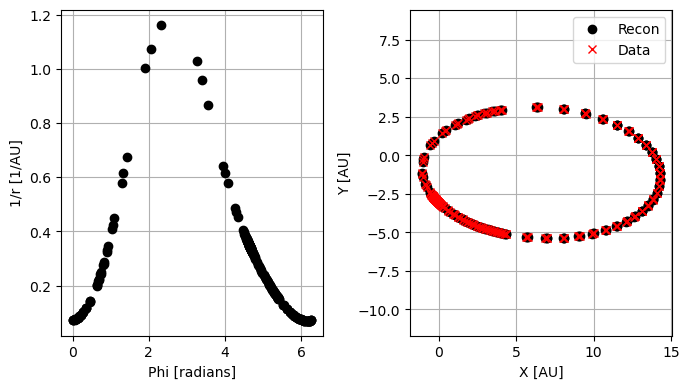

In [127]:
micro_arcsec_to_au = torch.pi / (3600*180) * 8 * 1000 * 206265 * 1e-2 # to units 1e-2 AU

data = pd.read_csv("data/simulated_data.csv")
y = torch.tensor(data.iloc[:,1], dtype=torch.float32) * micro_arcsec_to_au
x = torch.tensor(data.iloc[:,2], dtype=torch.float32) * micro_arcsec_to_au

#phi = np.arctan(y/x).unsqueeze(1)
u = (1/np.sqrt(x**2 + y**2))


phi = np.arccos(x*u) 
phi = torch.where(y<0., -phi, phi).float()
phi = torch.where(phi<0, phi+2*torch.pi, phi)
phi = torch.where(phi>2.2*torch.pi, phi-2*torch.pi, phi)


u = u.unsqueeze(1)
phi = phi.unsqueeze(1)

fig, ax = plt.subplots(figsize=(7,4), ncols=2)
#ax.set_xscale("log")

ax[0].plot(phi, u, 'ko')
ax[0].set_ylabel("1/r [1/AU]")
ax[0].set_xlabel("Phi [radians]")

ax[1].plot(np.cos(phi[:,0])/u[:,0], np.sin(phi[:,0])/u[:,0], 'ko', label="Recon")
ax[1].plot(x, y, 'rx', label="Data")
ax[1].set_ylabel("Y [AU]")
ax[1].set_xlabel("X [AU]")
ax[1].legend()

ax[1].axis('equal')

[axi.grid() for axi in ax]

plt.tight_layout()


In [172]:
# Initialize model
lr = 1e-3

model = PINN(1, 1, chans=[8,16,8]).to(device)
#optimizer = optim.SGD(lr=lr, params=model.parameters())
#optimizer = optim.Adagrad(lr=lr, params=model.parameters())
optimizer = optim.Adam(lr=lr, params=model.parameters())
criterion = nn.MSELoss()
#criterion = nn.L1Loss()

losses = [[], [], [], [], []]
params = [[], [], []]

phi_lin = torch.linspace(-2.1*torch.pi, 4.2*torch.pi, steps=1000).view(-1,1).requires_grad_(True)


#phys_loss_weight = .5

#phi_aug = phi # (phi + (torch.randint(low=0,high=5,size=phi.shape, device=device) - 2) * 2 * torch.pi)
#phi_lin_ = phi_lin.to(device)


#phi_aug = phi_aug.to(device)
#u = u.to(device)

phys_loss_weight = 1.
#phys_loss_weight = 1e4

alpha = 0.99
w_mse_old = 1.
w_phys_old = 1


batch_size = 16
batch_size_phys = 16


In [ ]:
epochs = 10_000

# For rel.diff. loss use phys_loss_weight = 1e0

for epoch in tqdm(range(epochs)):
    ind = torch.tensor(random.sample(range(len(phi)), batch_size))
    ind_p = torch.tensor(random.sample(range(len(phi_lin)), batch_size_phys))

    phi_ = phi[ind]
    u_ = u[ind]
    phi_lin_ = phi_lin[ind_p]

    phi_ = phi_.to(device)
    u_ = u_.to(device)
    phi_lin_ = phi_lin_.to(device)
    
    out = model(phi_)

    MSEloss = criterion(out, u_)
    #MSEloss = criterion(1/out, 1/u)    # Minimize difference in r
    #MSEloss = criterion(torch.log(out + 1e-8), torch.log(u + 1e-8))    # Minimize relative difference
    #MSEloss = torch.mean(torch.abs(out - u)**2 / (torch.abs(u) + 1e-8))    # Minimize MSE weightet by r

    #phi_lin = (torch.randn(1000, 1, requires_grad=True) * 10).to(device)
    PHYSloss = phys_loss_weight * model.physical_loss(phi_lin_)
    #PHYSloss = phys_loss_weight * model.physical_loss(phi_aug)
    #phys_loss_weight *= 1.005
    #phys_loss_weight = min(phys_loss_weight, max_phys_loss_weight)

    losses[3].append(MSEloss.item())
    losses[4].append(PHYSloss.item())

    # LOSS NORMALIZATION
    w_mse = ((MSEloss + PHYSloss)/(MSEloss)).item()
    w_phys = ((MSEloss + PHYSloss)/(PHYSloss)).item()

    w_mse = alpha * w_mse_old + (1 - alpha) * w_mse
    w_phys = alpha * w_phys_old + (1 - alpha) * w_phys

    MSEloss *= w_mse
    PHYSloss *= w_phys

    loss = MSEloss + PHYSloss

    w_mse_old = w_mse
    w_phys_old = w_phys


    optimizer.zero_grad()
    loss.backward()
    #MSEloss.backward()
    #PHYSloss.backward()
    optimizer.step()

    losses[0].append(loss.cpu().detach().numpy())
    losses[1].append(MSEloss.cpu().detach().numpy())
    losses[2].append(PHYSloss.cpu().detach().numpy())

    params[0].append(model.get_e().item())
    params[1].append(model.get_mu().item())
    #params[1].append(model.get_p().item())
    params[2].append(model.get_M().item())

    # phys_loss_weight += .005 # * (phys_loss_weight < 10)
    # phys_loss_weight += lr * 5

  2%|▏         | 210/10000 [00:00<00:32, 297.21it/s]

1.0
tensor(0.4483, grad_fn=<MeanBackward0>)
tensor(0.0642, grad_fn=<MeanBackward0>)


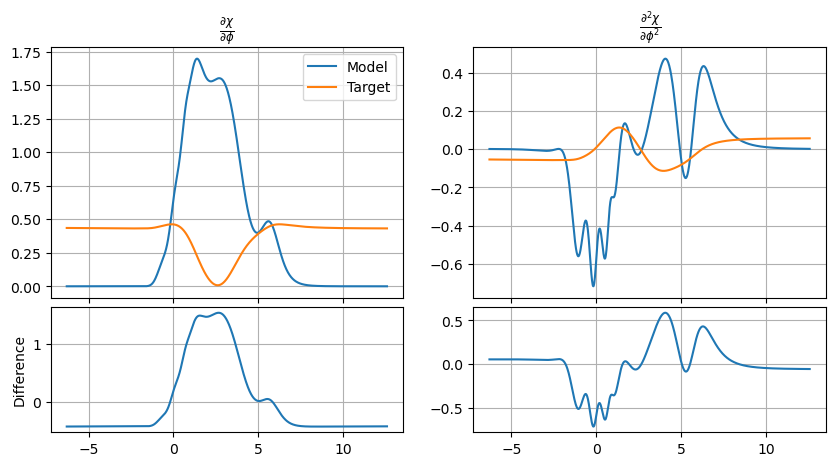

In [ ]:
def grad(out, inp):
    return torch.autograd.grad(out, 
                               inp, 
                               grad_outputs=torch.ones_like(out), 
                               create_graph=True)

_phi = torch.linspace(-2*torch.pi, 4*torch.pi, steps=1000).view(-1,1).requires_grad_(True)
chi = model.nn(_phi)

mu = model.get_mu().item()
#p  = self.get_p()
#M  = self.get_M()
e  = model.get_e().item()

dchi = grad(chi, _phi)[0]
ddchi = grad(dchi, _phi)[0]

ode1 = dchi**2 - (1 - 2*mu*(3 + e*torch.cos(chi)))
ode2 = ddchi - mu*e*torch.sin(chi)

print(phys_loss_weight)
print(torch.mean(ode1**2))
print(torch.mean(ode2**2))

_phi = _phi.detach().numpy()
dchi = dchi.detach().numpy()
ddchi = ddchi.detach().numpy()
chi = chi.detach()
ode1 = ode1.detach().numpy()
ode2 = ode2.detach().numpy()

fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(10,5), gridspec_kw={'height_ratios':[2,1]}, sharex=True)
ax[0,0].grid()
ax[0,0].set_title(r"$\frac{\partial \chi}{\partial \phi}$")
ax[0,0].plot(_phi, dchi**2, label="Model")
ax[0,0].plot(_phi, (1 - 2*mu*(3 + e*torch.cos(chi))), label="Target")
ax[0,0].legend()

ax[0,1].grid()
ax[0,1].set_title(r"$\frac{\partial^2 \chi}{\partial \phi^2}$")
ax[0,1].plot(_phi, ddchi)
ax[0,1].plot(_phi, mu*e*torch.sin(chi))

ax[1,0].grid()
ax[1,0].set_ylabel("Difference")
ax[1,0].plot(_phi, ode1)

ax[1,1].grid()
ax[1,1].plot(_phi, ode2)

plt.subplots_adjust(hspace=.05)

e = 0.890914261341095
p = 1.5753991603851318
M = 0.20087718963623047
mu = 0.1275087594985962
M-model-data = 0.9926570653915405


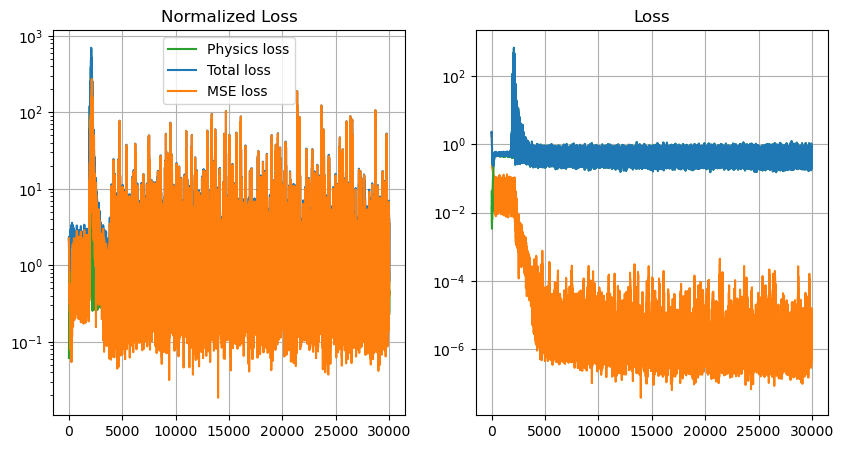

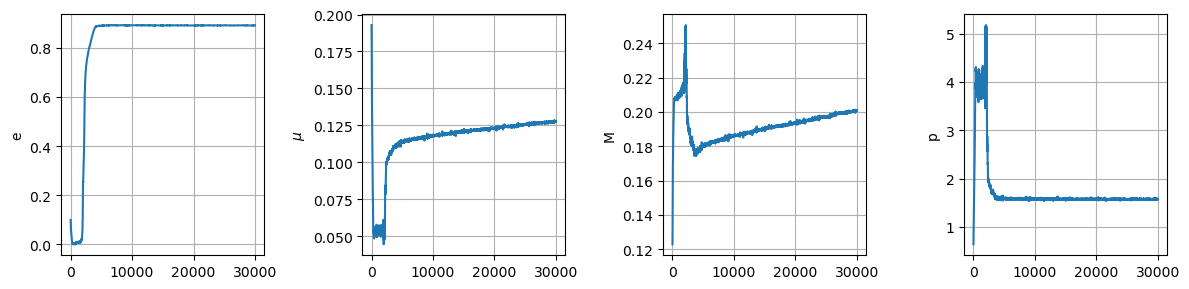

In [ ]:
print("e =", model.get_e().item())
#print("p =", model.get_M().item()/model.get_mu().item())
print("p =", model.get_p().item())
print("M =", model.get_M().item())
print("mu =", model.get_mu().item())


M_md = torch.mean(1 - torch.abs(model(phi.to(device)).cpu() - u)/u).item()
print("M-model-data =", M_md)


fig, (ax, ax2) = plt.subplots(figsize=(10,5), ncols=2)

ax.plot(losses[2], label="Physics loss", c="tab:green")
ax.plot(losses[0], label="Total loss", c="tab:blue")
ax.plot(losses[1], label="MSE loss", c="tab:orange")

ax2.plot(losses[3], label="MSE loss", c="tab:orange")
ax2.plot(losses[4], label="Physics loss", c="tab:green")
ax2.plot(np.array(losses[3]) + np.array(losses[4]), label="Total loss", c="tab:blue")

ax.grid(); ax2.grid()
ax.set_title("Normalized Loss"); ax2.set_title("Loss")

ax.legend()
ax.set_yscale("log"); ax2.set_yscale("log")
plt.show()


fig, ax = plt.subplots(ncols=4, figsize=(12,3))

ax[0].plot(params[0])
ax[0].set_ylabel("e")
ax[0].grid()

ax[1].plot(params[1])
ax[1].set_ylabel(r"$\mu$")
#ax[1].set_ylabel("p")
ax[1].grid()

ax[2].plot(params[2])
ax[2].set_ylabel("M")
ax[2].grid()

ax[3].plot(np.array(params[2])/np.array(params[1]))
ax[3].set_ylabel("p")
ax[3].grid()

plt.tight_layout()
plt.show()

# e  ~ 0.884 (0.884)
# p  ~ 228 (223)
# mu ~ 1.8e-4
# M  ~ 0.04239 AU

# M-model-data ~ 0.9755

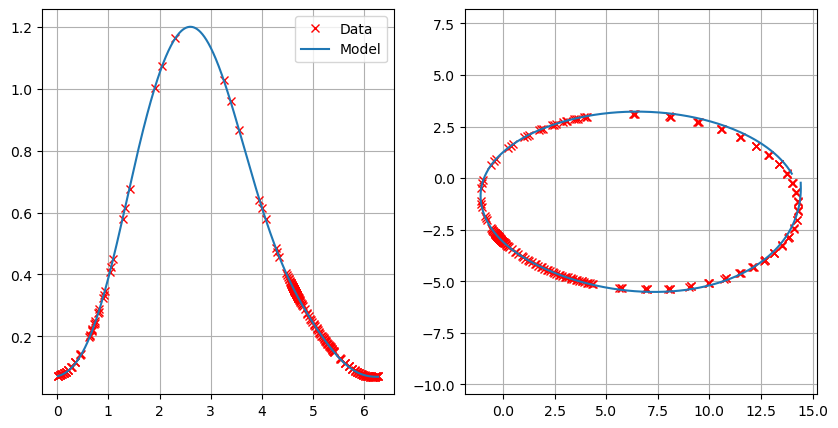

In [ ]:
fig, ax = plt.subplots(figsize=(10,5), ncols=2)
_phi = phi
_u = u
ax[0].plot(_phi, _u, 'rx', label="Data")


theta = torch.linspace(_phi.min(), _phi.max(), steps=1000, dtype=torch.float32).to(device)
u_ = model(theta.unsqueeze(1)).cpu().detach().numpy()[:,0]
theta = theta.cpu()
ax[0].plot(theta, u_, label="Model")
#ax[0].vlines(torch.pi/2, _u.min(), _u.max(), 'k', ls='--')
#ax[0].vlines(3*torch.pi/2, _u.min(), _u.max(), 'k', ls='--')
#ax[0].vlines(2*torch.pi, _u.min(), _u.max(), 'r', ls='--')
#ax[0].vlines(torch.pi, _u.min(), _u.max(), 'r', ls='--')


#ax[1].plot(x1, y1, 'rx')
#ax[1].plot(x2, y2, 'rx')
ax[1].plot(torch.cos(_phi[:,0])/_u[:,0], torch.sin(_phi[:,0])/_u[:,0], "rx")

r = 1/u_

theta = theta.numpy()
ax[1].plot(r*np.cos(theta), r*np.sin(theta));


[axi.grid() for axi in ax]
ax[1].axis('equal')
#ax[0].axis('equal')
ax[0].legend();
#ax.set_xscale("log")
#ax[0].set_xlim(0,3)
#ax[0].set_ylim(0,2)

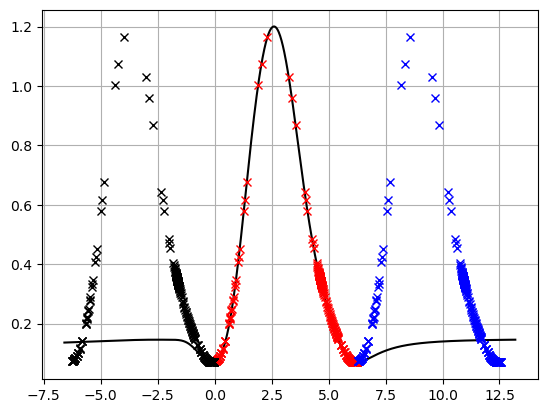

In [ ]:
fig, ax = plt.subplots()
ax.grid()

u_ = model(phi_lin).cpu().detach().numpy()[:,0]
theta = phi_lin.cpu().detach().numpy()

ax.plot(theta[:,0], u_, 'k')


ax.plot(phi.cpu(), u.cpu(), "rx")
phi_aug_ = phi + 2 * torch.pi
ax.plot(phi_aug_.cpu(), u.cpu(), 'bx')
phi_aug = phi - 2 * torch.pi
ax.plot(phi_aug.cpu(), u.cpu(), 'kx')

#plt.xlim(-2, -1)
#r = 1/u_
#theta = phi_lin.detach().numpy()
#ax.plot(r*np.cos(theta[:,0]), r*np.sin(theta[:,0]));


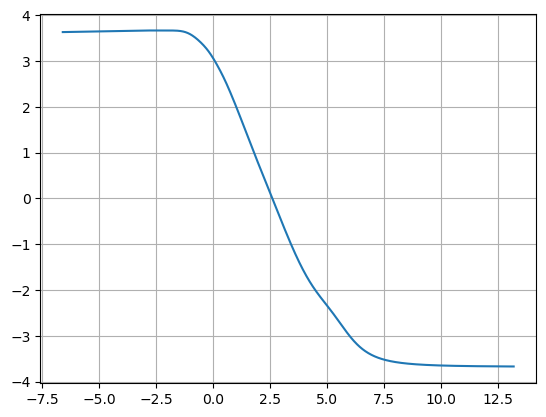

In [ ]:
x = phi_lin
y = model.nn(x)

x = x.cpu().detach().numpy()
y = y.cpu().detach().numpy()

plt.plot(x,y)
plt.grid()

In [ ]:
state = {
    'model': model.state_dict(),
    'optimizer': optimizer.state_dict(),
}

#torch.save(state, f'S-STAR-PINN.pth')